## Russian Language Model

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *
import html

PATH=Path("../../../Russian_Language_Model/input/")

LM_PATH=PATH/'rlm'
LM_PATH.mkdir(exist_ok=True)
(LM_PATH/'tmp').mkdir(exist_ok=True)

!ls $PATH

lenta_data.csv	ruwiki-latest-pages-articles.xml
rlm		ruwiki-latest-pages-articles.xml.bz2


## Lenta.ru

In [ ]:
df = pd.read_csv(PATH/"lenta_data.csv", usecols=["text"])
df.tail()

In [ ]:
texts = df.text
trn_texts, val_texts = sklearn.model_selection.train_test_split(texts, test_size=0.1)
len(trn_texts), len(val_texts)

In [ ]:
col_names = ['labels','text']

df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

print(len(df_trn))
df_trn = df_trn[df_trn.text.str.len()<11000] #solving out of memory problem
print(len(df_trn))

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'valid.csv', header=False, index=False)

## Language model tokens

In [2]:
chunksize=56000

def fixup(x):
    x = x.replace(". . .","...")
    x = " , ".join(x.split(","))
    x = " . ".join(x.split("."))
    x = x.replace(".  .  .","...")

#     TODO: LATIN in text.py
#     res = []
#     for y in re.compile(r'  +').sub(' ', html.unescape(x)):
#         if len(re.findall("[A-Za-z]+", y))!=0:
#             res.append("latin_letters")
#         res.append(y)
#     return res

    return re.compile(r'  +').sub(' ', html.unescape(x))
    
def get_texts(df):
    labels = df[0].values.astype(np.int64)
    texts = '\n' + df[1].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts), 'xx')
    return tok, list(labels)

def get_all(df):
    tok, labels = [], []
    for i, r in tqdm(enumerate(df)):
        tok_, labels_ = get_texts(r)
        tok += tok_;
        labels += labels_
    return tok, labels

In [ ]:
df_val = pd.read_csv(LM_PATH/'valid.csv', header=None, chunksize=chunksize)
tok_val, val_labels = get_all(df_val)

In [ ]:
from random import choice
choice(tok_val)

In [ ]:
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [ ]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
tok_trn, trn_labels = get_all(df_trn)

In [ ]:
np.save(LM_PATH/'tmp'/'tok_trn_0.npy', tok_trn[:300000])
np.save(LM_PATH/'tmp'/'tok_trn_1.npy', tok_trn[300000:])

In [ ]:
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [ ]:
tok_trn = np.array([])
for i in tqdm(range(2)):
    tok_trn = np.append(tok_trn, np.load(LM_PATH/'tmp'/f'tok_trn_{i}.npy'))

In [ ]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

In [ ]:
max_vocab = 60000
min_freq = 2

In [ ]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [ ]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

In [ ]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

## Language model

In [3]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

vs=len(itos)
vs,len(trn_lm)

(60002, 572053)

In [4]:
em_sz,nh,nl = 400,1150,3

wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [5]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [6]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [9]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
#learner.unfreeze()

In [10]:
lr=1e-3
lrs = lr

In [11]:
learner.fit(lrs/2, 1, wds=wd, use_clr = (32,2,0.95,0.85), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      4.161831   3.972022   0.332845  



[array([3.97202]), 0.3328445133081919]

In [12]:
# epoch      trn_loss   val_loss   accuracy                         
#     0      4.161831   3.972022   0.332845 
learner.save('lm_last_ft')

In [13]:
learner.load('lm_last_ft')

In [14]:
learner.unfreeze()

In [15]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2,0.95,0.85), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      3.998913   3.726796   0.352619  



[array([3.7268]), 0.35261850457849936]

In [16]:
# epoch      trn_loss   val_loss   accuracy                         
#     0      3.998913   3.726796   0.352619
learner.save('lm0')

In [17]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10,0.95,0.85), cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      3.941622   3.694514   0.351323  
    1      3.856177   3.594045   0.362067                         
    2      3.833942   3.537766   0.368743                         
    3      3.780922   3.485864   0.374656                         
    4      3.72164    3.443001   0.379537                         



[array([3.443]), 0.3795374637056252]

In [18]:
# epoch      trn_loss   val_loss   accuracy                         
#     0      3.941622   3.694514   0.351323  
#     1      3.856177   3.594045   0.362067                         
#     2      3.833942   3.537766   0.368743                         
#     3      3.780922   3.485864   0.374656                         
#     4      3.72164    3.443001   0.379537 
learner.save('lm1')

In [19]:
learner.save_encoder('lm_enc1')

In [22]:
learner.load('lm1')

In [23]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10,0.95,0.85), cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 19/34831 [00:03<1:43:33,  5.60it/s, loss=3.69]

Exception in thread Thread-14:
Traceback (most recent call last):
  File "/home/ppleskov/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ppleskov/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ppleskov/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                         
    0      3.856115   3.581695   0.364074  
    1      3.792789   3.520108   0.370411                         
    2      3.77312    3.466003   0.375997                         
    3      3.702297   3.414085   0.381718                         
    4      3.652442   3.375404   0.386131                         



[array([3.3754]), 0.3861314170836153]

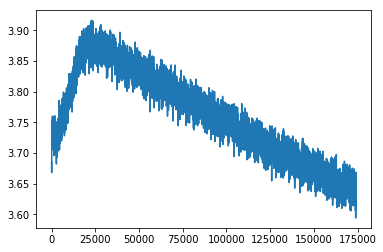

In [24]:
# epoch      trn_loss   val_loss   accuracy                         
#     0      3.856115   3.581695   0.364074  
#     1      3.792789   3.520108   0.370411                         
#     2      3.77312    3.466003   0.375997                         
#     3      3.702297   3.414085   0.381718                         
#     4      3.652442   3.375404   0.386131  
learner.sched.plot_loss()

In [ ]:
learner.save('lm2')
learner.save_encoder('lm_enc2')


In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10,0.95,0.85), cycle_len=10)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      3.797437   3.515695   0.36947   
    1      3.793308   3.500449   0.371573                         
 53%|█████▎    | 18570/34831 [57:45<50:34,  5.36it/s, loss=3.74]  

In [ ]:
learner.save('lm3')
learner.save_encoder('lm_enc3')

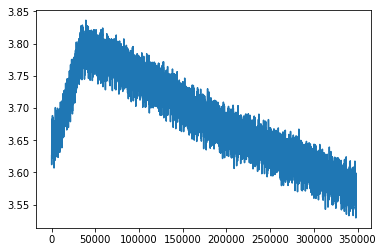

In [28]:
learner.sched.plot_loss()

In [29]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10,0.95,0.85), cycle_len=5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                         
    0      3.747992   3.462063   0.375851  
    1      3.702181   3.417244   0.380675                         
    2      3.668825   3.379398   0.385025                         
    3      3.62155    3.337951   0.389478                         
    4      3.590524   3.303631   0.393626                         



[array([3.30363]), 0.3936256984729828]

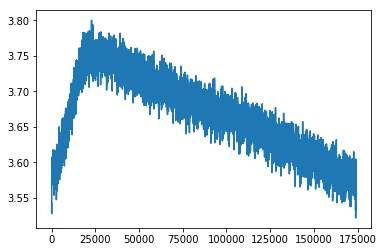

In [30]:
learner.sched.plot_loss()

In [31]:
# epoch      trn_loss   val_loss   accuracy                         
#     0      3.747992   3.462063   0.375851  
#     1      3.702181   3.417244   0.380675                         
#     2      3.668825   3.379398   0.385025                         
#     3      3.62155    3.337951   0.389478                         
#     4      3.590524   3.303631   0.393626   

learner.save('lm4')
learner.save_encoder('lm_enc4')